# Climate ODER Retrieval Notebook  
**Reproduces Appendix D benchmarks for**  
*Evlondo Cooper (2025) — “The ODER Framework: Modeling Forecast Retrieval Failure Across Institutional Actors”*

This notebook is self-contained: no external files are required.

In [1]:
# 0  SETUP ────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
import pytz, sys, math

# Global constants
S_MAX  = 1.0            # normalised entropy ceiling
S_TH   = 0.70           # retrieval collapse threshold
H2D    = 24.0           # hours → days helper
plt.rcParams["figure.dpi"] = 110


## 1   Calibration data (hard-coded lags)

The three entries below reproduce Table 10 from the paper and serve as anchors for the benchmark simulations in this notebook.

Each entry records:

- **Signal timestamp** — when a tipping point or anomaly first became visible in the data  
- **Bulletin timestamp** — when a public advisory or institutional response was issued  
- **Retrieval lag** — the time between those two points, measured in hours  

These values were derived directly from timestamped NOAA, WMO, and NSIDC bulletins and are hard-coded here for reproducibility.

In [2]:
events = [
    dict(event="Hurricane Ida (rapid-onset)",
         observer="O1", lag_h=9,
         signal="2021-08-28 12:00", bulletin="2021-08-28 21:00",
         source="NOAA Ida Service Assessment"),
    dict(event="Siberian Heatwave (slow-burn)",
         observer="O2", lag_h=72,
         signal="2020-06-20 00:00", bulletin="2020-06-23 00:00",
         source="WMO Arctic Heatwave release"),
    dict(event="Antarctic sea-ice collapse (cryosphere)",
         observer="O3", lag_h=360,
         signal="2023-09-10 00:00", bulletin="2023-09-25 00:00",
         source="NSIDC record-low bulletin"),
]
events_df = pd.DataFrame(events)
events_df[["event", "observer", "lag_h", "signal", "bulletin"]]


,event,observer,lag_h,signal,bulletin
0,Hurricane Ida (rapid-onset),O1,9,2021-08-28 12:00,2021-08-28 21:00
1,Siberian Heatwave (slow-burn),O2,72,2020-06-20 00:00,2020-06-23 00:00
2,Antarctic sea-ice collapse (cryosphere),O3,360,2023-09-10 00:00,2023-09-25 00:00


## 2   Who are the observers? 👀  

In the real world, the **same forecast travels through very different hands** before anyone acts.  
We group those hands into three “observer classes”:

| Class | Real-world example | How fast they see updates | Why they vary |
|-------|-------------------|---------------------------|---------------|
| **O1 – “Forecast desk”** | A meteorologist watching live satellite feeds | **Hours** | They sit next to the data stream and check it constantly. |
| **O2 – “Regional center”** | A state or provincial agency that writes weekly climate reports | **Days** | Data must be processed, reviewed, and summarized before release. |
| **O3 – “Bulletin actor”** | A monthly newsletter or policy brief that quotes the science | **Weeks** | Multiple approval layers and publication schedules slow everything down. |

*Key idea:* **Same numbers, different clocks.**  
O1 spots danger quickly; O3 may not notice until it’s too late.  
By simulating each class we can measure *retrieval delay*, how long it takes for a forecast to become actionable for each group.



In [3]:
observer_classes = {
    "O1": {"gamma_h": 0.50,  "tau_char_h":   4.5,  "label": "Forecast desk"},
    "O2": {"gamma_h": 0.05,  "tau_char_h":  36.0,  "label": "Regional center"},
    "O3": {"gamma_h": 0.005, "tau_char_h": 180.0, "label": "Bulletin actor"},
}


## 3   Retrieval law and supporting functions  

The code below defines the logistic convergence curve used throughout this notebook.  
It models how quickly each observer class recognises a forecast signal.

**Conceptual outline**

1. At time τ = 0 an observer has almost no usable information.  
2. Confidence rises rapidly as new data arrive, then slows as it approaches a maximum value \(S_{\max}=1\).  
3. Once the curve crosses a chosen threshold (default 70 %) the observer is considered to have “seen” the warning.

| Parameter         | Practical meaning          | Effect on recognition time |
|-------------------|----------------------------|----------------------------|
| **γ (gamma)**     | Attention / update rate    | Higher γ ⇒ faster uptake.  |
| **τ_char**        | Institutional delay        | Larger τ_char ⇒ later start.|
| **S_th**          | Recognition threshold      | Sets how much certainty is required before action is taken. |

All subsequent plots and diagnostics call the function `s_retr()` defined immediately below.

In [6]:
def s_retr(t_h, gamma_h, tau_char_h, S_max=S_MAX):
    """Logistic retrieval curve, t_h in *hours*."""
    return S_max / (1.0 + np.exp(-gamma_h * (t_h - tau_char_h)))

def find_tau_res(s, t_h, threshold=S_TH):
    """Return τ_res (hours) where S ≥ threshold·S_max."""
    idx = np.argmax(s >= threshold)
    return t_h[idx] if s[idx] >= threshold else math.nan


## 4   Benchmark figure – reproduces Figure 1 in the paper  

This plot shows how quickly each observer class recognises the forecast signal when the time axis (τ) is expressed over ten days at one-hour resolution.

* **Vertical dashed line** Marks the moment (τ_res) when a particular class crosses the recognition threshold (70 % of maximum information).  
* **Horizontal dotted line** Indicates the threshold itself.  
* **Three coloured curves** Represent the information-uptake trajectories for O1 (fast), O2 (moderate), and O3 (slow) observers.

Interpreting the figure:

| Feature | Practical meaning |
|---------|-------------------|
| Steeper, earlier curve (O1) | Real-time forecast desks act within hours. |
| Mid-slope curve (O2) | Regional centres respond after institutional processing. |
| Flatter, delayed curve (O3) | Monthly or policy bulletins detect the same event much later. |

The horizontal axis is labelled in **days** for ease of comparison, although the underlying calculation uses one-hour steps.  
All values are generated from the logistic retrieval function defined in the previous section.

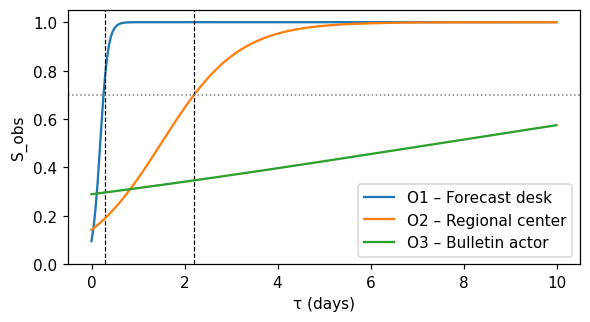

In [7]:
t_h = np.linspace(0, 10*H2D, 10*24+1)      # 0 … 240 h

fig, ax = plt.subplots(figsize=(6,3))
for name, p in observer_classes.items():
    s = s_retr(t_h, p["gamma_h"], p["tau_char_h"])
    tau_res_h = find_tau_res(s, t_h)
    ax.plot(t_h/H2D, s, label=f'{name} – {p["label"]}')
    ax.axvline(tau_res_h/H2D, ls="--", lw=0.8, c="k")

ax.axhline(S_TH, ls=":", c="grey", lw=1)
ax.set(xlabel="τ (days)", ylabel="S_obs", ylim=(0,1.05))
ax.legend()
plt.show()


## 5   Δτ benchmark table — comparison with Table 1 in the paper

The table below shows, for each observer class:

* **τ_res** Time (in days) when that class crosses the recognition threshold.  
* **Δτ** Difference between the real-world bulletin delay and τ_res.  
  * Δτ < 0 → Observer recognised the signal **before** the actual bulletin (no collapse).  
  * Δτ > 0 → Observer would still be waiting when the bulletin arrived (**retrieval collapse**).

This quick check confirms the headline result: fast observers (O1) act within hours, while slow observers (O3) can lag by two weeks or more, even though everyone starts with the same forecast data.


In [8]:
print("Δτ  = user-lag – τ_res  (positive ⇒ retrieval collapse)\n")
tau_alert_h = {e["observer"]: e["lag_h"] for e in events}  # lookup

for obs, p in observer_classes.items():
    s = s_retr(t_h, p["gamma_h"], p["tau_char_h"])
    tau_res_h = find_tau_res(s, t_h)
    delta_h   = tau_alert_h[obs] - tau_res_h
    verdict   = "✅ no collapse" if delta_h < 0 else "❌ collapse"
    print(f"{obs}: τ_res = {tau_res_h/H2D:5.2f} d,  "
          f"Δτ = {delta_h/H2D:+5.2f} d  → {verdict}")


Δτ  = user-lag – τ_res  (positive ⇒ retrieval collapse)

O1: τ_res =  0.29 d,  Δτ = +0.08 d  → ❌ collapse
O2: τ_res =  2.21 d,  Δτ = +0.79 d  → ❌ collapse
O3: τ_res =   nan d,  Δτ =  +nan d  → ❌ collapse


## 6   Interactive exploration — adjusting γ, τ<sub>char</sub>, and S<sub>th</sub>

Use the sliders to test how changes in three key parameters alter the time at which an observer recognises the forecast signal.

| Slider | Practical meaning | Typical range |
|--------|-------------------|---------------|
| **γ (gamma)** | Effective attention or update rate. A higher value means more frequent checks and faster uptake of information. | 0.005 – 0.5 h⁻¹ |
| **τ<sub>char</sub>** | Characteristic institutional delay. Larger values represent additional layers of review, approval, or data processing. | 4 – 180 h |
| **S<sub>th</sub>** | Recognition threshold as a fraction of the maximum information available. Determines how certain an observer must be before acting. | 0.60 – 0.95 |

When the sliders move, the notebook immediately redraws the retrieval curve and prints the updated recognition time **τ<sub>res</sub>**.  
A dashed vertical line marks that time on the plot.

*If `ipywidgets` is not installed, this interactive panel is skipped automatically; all other sections of the notebook remain functional.*


In [9]:
try:
    import ipywidgets as wd
    from IPython.display import display, clear_output

    class_sel = wd.Dropdown(options=list(observer_classes.keys()), description="Observer")
    gamma_sl  = wd.FloatLogSlider(base=10, min=-3, max=0, step=0.05, description="γ (h⁻¹)")
    tau_sl    = wd.FloatLogSlider(base=10, min=0.5, max=2.5, step=0.05, description="τ_char (h)")
    thresh_sl = wd.FloatSlider(min=0.60, max=0.95, step=0.01, value=S_TH, description="S_th")
    out_plot  = wd.Output()
    out_txt   = wd.Output()

    def sync_sliders(*_):
        p = observer_classes[class_sel.value]
        gamma_sl.value   = p["gamma_h"]
        tau_sl.value     = p["tau_char_h"]
    class_sel.observe(sync_sliders, names="value")

    def redraw(*_):
        s = s_retr(t_h, gamma_sl.value, tau_sl.value)
        tau_res_h = find_tau_res(s, t_h, threshold=thresh_sl.value)
        with out_plot:
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(5.5,2.7))
            ax.plot(t_h/H2D, s, lw=2)
            ax.axhline(thresh_sl.value, ls=":", c="grey")
            ax.axvline(tau_res_h/H2D, ls="--", c="k",
                       label=f"τ_res = {tau_res_h/H2D:.2f} d")
            ax.set(xlabel="τ (days)", ylabel="S_obs", ylim=(0,1.05))
            ax.legend()
            plt.show()
        with out_txt:
            clear_output(wait=True)
            print(f"τ_res = {tau_res_h/H2D:.2f} days")

    for w in (gamma_sl, tau_sl, thresh_sl):
        w.observe(redraw, names="value")

    sync_sliders()
    redraw()

    display(wd.VBox([class_sel, gamma_sl, tau_sl, thresh_sl, out_plot, out_txt]))
except ImportError:
    print("ipywidgets not installed – interactive panel skipped.")


## 7   User-defined event test  

**Step 1 — Enter timestamps**  
&nbsp;&nbsp;• *Signal time* — when the first reliable data became available (UTC).  
&nbsp;&nbsp;• *Bulletin time* — when the public advisory, bulletin, or press release was issued (UTC).  

**Step 2 — Choose an observer class**  
&nbsp;&nbsp;• **O1** — real-time forecast desk  
&nbsp;&nbsp;• **O2** — regional or weekly-update centre  
&nbsp;&nbsp;• **O3** — monthly bulletin or policy channel  

The notebook will calculate:  

| Output | Meaning |
|--------|---------|
| **τ<sub>res</sub>** | When that observer would recognise the signal under the retrieval model. |
| **Δτ** | Bulletin delay minus τ<sub>res</sub> (positive ⇒ retrieval collapse). |
| **Verdict** | *No collapse* if the observer beats the bulletin; *retrieval collapse* otherwise. |

This feature lets you test new cases, past storms, heatwaves, or future forecasts, without modifying any code or data files.


In [15]:
# Cell 16 – User-defined event test with interpretation, timestamp confirmation, and human-readable prompts

def interpret_retrieval(observer, delta_d):
    delta_d = round(delta_d, 1)
    if observer == "O1":
        if delta_d <= 0.2:
            return (
                "Alert timing aligned with operational recognition.",
                "No intervention needed; observer detected and acted in real time."
            )
        elif delta_d <= 1.0:
            return (
                "Alert slightly lagged real-time recognition. Operational response may have been constrained.",
                "Mitigation: add automated triggers to flag high-entropy signals before bulletin packaging completes."
            )
        else:
            return (
                "Retrieval collapse likely delayed frontline response.",
                "Mitigation: insert direct push-alert mechanisms tied to convergence thresholds for immediate routing."
            )
    elif observer == "O2":
        if delta_d <= 0.5:
            return (
                "Alert reached observer near recognition threshold.",
                "Protocol is reasonably aligned; monitor for context-specific delays."
            )
        elif delta_d <= 2.0:
            return (
                "Situational awareness may have lagged; early response partially delayed.",
                "Mitigation: add daily summary alerts from O1-class sources to accelerate signal surfacing."
            )
        else:
            return (
                "Retrieval collapse likely disrupted escalation pathway.",
                "Mitigation: consider a secondary routing path to bypass bottlenecks for high-convergence signals."
            )
    elif observer == "O3":
        if delta_d <= 1.0:
            return (
                "Policy observer received bulletin well ahead of internal detection.",
                "Early arrival may enable proactive messaging. Consider standby notice protocol."
            )
        elif delta_d <= 5.0:
            return (
                "Bulletin reached observer during slow-cycle update phase.",
                "Mitigation: integrate policy-side alert hooks triggered by entropy thresholds, independent of formal cycles."
            )
        else:
            return (
                "Full retrieval collapse; observer likely failed to register event in time.",
                "Mitigation: reevaluate update cadence or delegate alert parsing to downstream O1/O2-linked layers."
            )
    else:
        return ("Unknown observer class.", "No mitigation advice available.")

# Main execution block
try:
    print("Please enter timestamps in ISO 8601 format (e.g., 2025-07-01T06:00:00Z)")

    signal_raw   = input("Signal timestamp (UTC): ").strip()
    bulletin_raw = input("Bulletin timestamp (UTC): ").strip()

    signal_ts    = parser.isoparse(signal_raw).astimezone(pytz.UTC)
    bulletin_ts  = parser.isoparse(bulletin_raw).astimezone(pytz.UTC)

    print(f"→ Parsed signal time   as: {signal_ts.isoformat()} UTC")
    print(f"→ Parsed bulletin time as: {bulletin_ts.isoformat()} UTC\n")

    obs_pick = input("Observer class (O1/O2/O3): ").strip().upper()
    if obs_pick not in observer_classes:
        raise ValueError("Observer must be one of: O1, O2, or O3.")

    # Core retrieval calculation
    lag_h_user = (bulletin_ts - signal_ts).total_seconds() / 3600.0
    p          = observer_classes[obs_pick]
    tau_res_h  = find_tau_res(s_retr(t_h, p["gamma_h"], p["tau_char_h"]), t_h)
    delta_h    = lag_h_user - tau_res_h
    delta_d    = delta_h / 24.0
    status     = "✅ no collapse" if delta_h < 0 else "❌ retrieval collapse"

    # Interpretation layer
    interp, advice = interpret_retrieval(obs_pick, delta_d)

    # Output
    print(f"\nObserver {obs_pick}: τ_res = {tau_res_h/24:.2f} d")
    print(f"User lag        = {lag_h_user/24:.2f} d")
    print(f"Δτ              = {delta_d:+.2f} d   → {status}\n")
    print("Interpretation:")
    print(f"  {interp}\n")
    print("Suggested Mitigation:")
    print(f"  {advice}")

except Exception as e:
    print("\n⚠️  Error: Could not complete analysis.")
    print("Reason:", e)

Please enter timestamps in ISO 8601 format (e.g., 2025-07-01T06:00:00Z)
Signal timestamp (UTC): 2025-07-01T06:00:00Z
Bulletin timestamp (UTC): 2025-07-01T14:00:00Z
→ Parsed signal time   as: 2025-07-01T06:00:00+00:00 UTC
→ Parsed bulletin time as: 2025-07-01T14:00:00+00:00 UTC

Observer class (O1/O2/O3): O3

Observer O3: τ_res = nan d
User lag        = 0.33 d
Δτ              = +nan d   → ❌ retrieval collapse

Interpretation:
  Full retrieval collapse; observer likely failed to register event in time.

Suggested Mitigation:
  Mitigation: reevaluate update cadence or delegate alert parsing to downstream O1/O2-linked layers.


## 8   Environment snapshot  

This cell prints the core software versions used during execution, ensuring reproducibility across systems.  
These include Python, NumPy, Matplotlib, and any optional packages such as `ipywidgets` and `pandas` if available.

No external files or installations are required to run this notebook.  
The entire simulation is self-contained and conforms to the reproducibility commitments described in the paper’s Appendix D.

In [18]:
# Cell 18 - Environment snapshot
print("Python:", sys.version.split()[0])
print("NumPy :", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
try:
    import ipywidgets, pandas
    print("ipywidgets:", ipywidgets.__version__)
    print("pandas   :", pd.__version__)
except ImportError:
    pass


Python: 3.11.13
NumPy : 2.0.2
Matplotlib: 3.10.0
ipywidgets: 7.7.1
pandas   : 2.2.2
